### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
import joblib

### Load the data

In [2]:
email_df = pd.read_csv('data/email_table.csv')
opened_df = pd.read_csv('data/email_opened_table.csv')
clicked_df = pd.read_csv('data/link_clicked_table.csv')


In [3]:
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

### Preprocessing the data

In [4]:
le_text = LabelEncoder()
le_version = LabelEncoder()

email_df['email_text'] = le_text.fit_transform(email_df['email_text'].astype(str))
email_df['email_version'] = le_version.fit_transform(email_df['email_version'].astype(str))


In [5]:
email_df = pd.get_dummies(email_df, columns=['weekday', 'user_country']).astype(int)

### Split

In [6]:
X = email_df.drop(columns=['email_id', 'clicked'])
y = email_df['clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [ ]:
# Define the hyperparameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],  
    'penalty': ['l2'],  
    'tol': [1e-4, 1e-3, 1e-2]  
}

# Set up GridSearchCV for Logistic Regression with balanced class weights
lr_grid = GridSearchCV(
    estimator=LogisticRegression(
        class_weight='balanced', 
        max_iter=1500,
        warm_start=True,
        random_state=42
    ),
    param_grid=lr_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the scaled training data
lr_grid.fit(X_train_scaled, y_train)

# Retrieve the best estimator found by grid search
best_lr = lr_grid.best_estimator_

# Print the best hyperparameters and corresponding F1 score
print("Best Logistic Regression Params:", lr_grid.best_params_)
print(f"Best F1 Score: {lr_grid.best_score_:.4f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Logistic Regression Params: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Best F1 Score: 0.3287


### Random Forest

In [ ]:
# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False], 
    'class_weight': ['balanced', 'balanced_subsample'] 
}

# Set up RandomizedSearchCV for Random Forest
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=30,
    scoring='f1', 
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the random search on the training data
rf_random.fit(X_train, y_train)

# Retrieve the best estimator found by random search
best_rf = rf_random.best_estimator_

# Print the best hyperparameters and corresponding F1 score
print("Best Random Forest Parameters:")
for param, value in rf_random.best_params_.items():
    print(f"{param}: {value}")
print(f"Best F1 Score: {rf_random.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Random Forest Parameters:
n_estimators: 500
min_samples_split: 10
min_samples_leaf: 2
max_features: sqrt
max_depth: None
class_weight: balanced
bootstrap: True
Best F1 Score: 0.3549


### XGBoost

In [ ]:
# Calculate the scale_pos_weight for XGBoost to handle class imbalance
scale = (y==0).sum() / (y==1).sum()

# Define the hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500], 
    'max_depth': [3, 4, 5, 6, 8, 10], 
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  
    'min_child_weight': [1, 3, 5, 7], 
    'scale_pos_weight': [scale] 
}

# Set up RandomizedSearchCV for XGBoost
xgb_random = RandomizedSearchCV(
    estimator=XGBClassifier(
        eval_metric='logloss',
        verbosity=0,
        random_state=42
    ),
    param_distributions=xgb_param_grid,
    n_iter=35, 
    scoring='f1',
    cv=8,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the random search on the training data
xgb_random.fit(X_train, y_train)

# Retrieve the best estimator found by random search
best_xgb = xgb_random.best_estimator_

# Print the best hyperparameters and corresponding F1 score
print("Best XGBoost Parameters:")
for param, value in xgb_random.best_params_.items():
    print(f"{param}: {value}")
print(f"Best F1 Score: {xgb_random.best_score_:.4f}")

Fitting 8 folds for each of 35 candidates, totalling 280 fits
Best XGBoost Parameters:
subsample: 0.6
scale_pos_weight: 46.192071731949035
n_estimators: 500
min_child_weight: 3
max_depth: 10
learning_rate: 0.01
gamma: 0.3
colsample_bytree: 0.7
Best F1 Score: 0.3473


### Model Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, name='Model'):
    # Predict class labels
    y_pred = model.predict(X_test)
    # Predict probabilities if available, otherwise use predictions
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    print(f"Results for {name}:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
    print()

# Evaluate Logistic Regression on scaled test data
evaluate_model(best_lr, X_test_scaled, y_test, "Logistic Regression")
# Evaluate Random Forest on original test data
evaluate_model(best_rf, X_test, y_test, "Random Forest")
# Evaluate XGBoost on original test data
evaluate_model(best_xgb, X_test, y_test, "XGBoost")

Accuracy:  0.9166
Precision: 0.2098
Recall:    0.9691
F1 Score:  0.3450
ROC AUC:   0.9508

Accuracy:  0.9454
Precision: 0.2357
Recall:    0.6291
F1 Score:  0.3430
ROC AUC:   0.9460

Accuracy:  0.9244
Precision: 0.2216
Recall:    0.9294
F1 Score:  0.3578
ROC AUC:   0.9459



### Email Campaign Basic Metrics

In [ ]:
#  Calculate basic email campaign metrics
total_emails = len(email_df)
opened_emails = len(opened_df)
clicked_emails = len(clicked_df)

open_rate = opened_emails / total_emails * 100
click_rate = clicked_emails / total_emails * 100
click_to_open_rate = clicked_emails / opened_emails * 100

print(f"Campaign Performance Metrics:")
print(f"Open rate: {open_rate:.2f}%")
print(f"Click rate: {click_rate:.2f}%")
print(f"Click-to-open rate: {click_to_open_rate:.2f}%")

Campaign Performance Metrics:
Open rate: 10.35%
Click rate: 2.12%
Click : Open rate: 20.48%


### Segment Analysis


Performance by email_text:
 email_text  count  open_rate  click_rate
short_email  49724  11.585954    2.387177
 long_email  50276   9.117670    1.853767


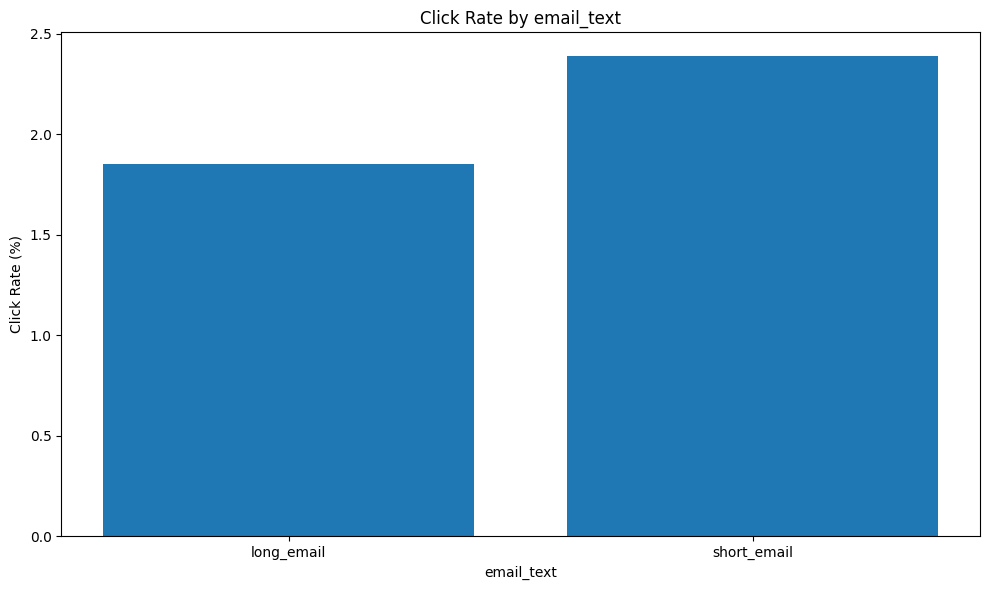


Performance by email_version:
email_version  count  open_rate  click_rate
 personalized  49791  12.775401    2.729409
      generic  50209   7.934832    1.513673


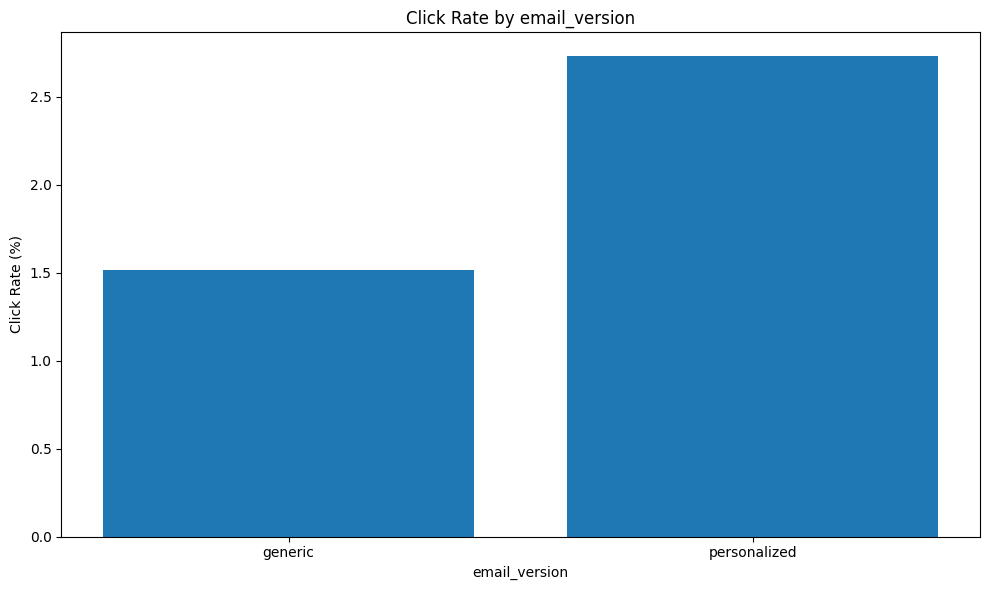


Performance by hour:
 hour  count  open_rate  click_rate
   23    145   8.275862    4.137931
   24     69  15.942029    2.898551
   10   8180  13.239609    2.823961
   11   7483  12.655352    2.712816
    9   8529  12.568883    2.579435
   12   6508  12.446220    2.566073
   15   3493  10.535356    2.490696
   16   2759  10.474810    2.319681
   14   4580  10.938865    2.074236
   13   5581  10.912023    1.988891
   22    204   6.372549    1.960784
    3   4610   8.459870    1.952278
    8   8398   8.847345    1.893308
   17   1893  10.935024    1.848917
    7   8204   9.007801    1.828376
    1   2703   8.842027    1.812801
    5   6551   8.212487    1.801252
    6   7465   9.028801    1.714668
   19    905   7.513812    1.657459
    2   3676   8.786725    1.632209
    4   5622   8.822483    1.618641
   18   1421   9.429979    1.618578
   20    656   8.841463    1.219512
   21    365   5.753425    0.821918


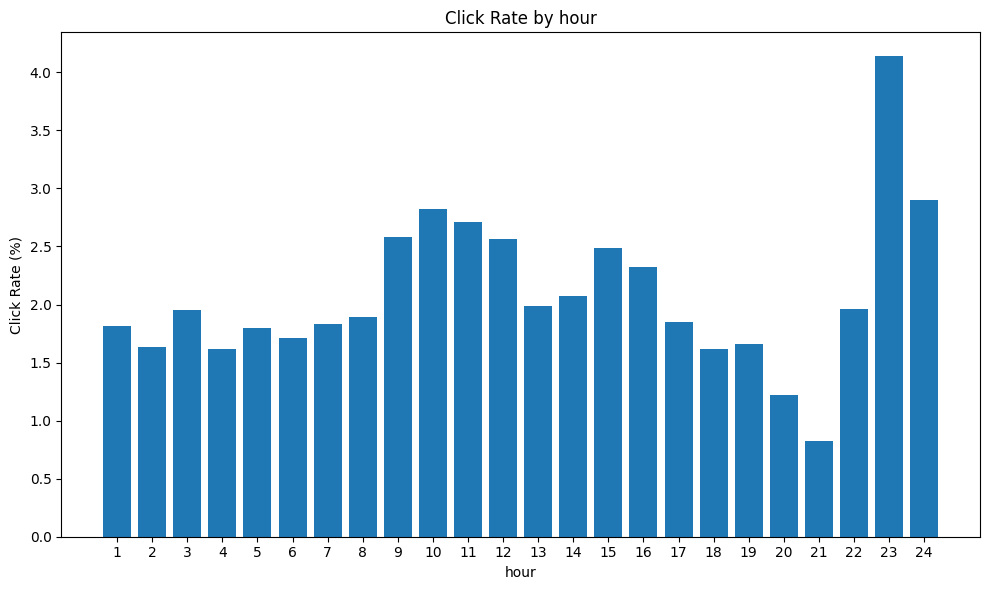


Performance by weekday:
  weekday  count  open_rate  click_rate
Wednesday  14084  12.027833    2.761999
  Tuesday  14143  12.048363    2.488864
 Thursday  14277  11.844225    2.444491
   Monday  14363  11.606210    2.290608
 Saturday  14569   8.765186    1.784611
   Sunday  14387   8.764857    1.675123
   Friday  14177   7.413416    1.403682


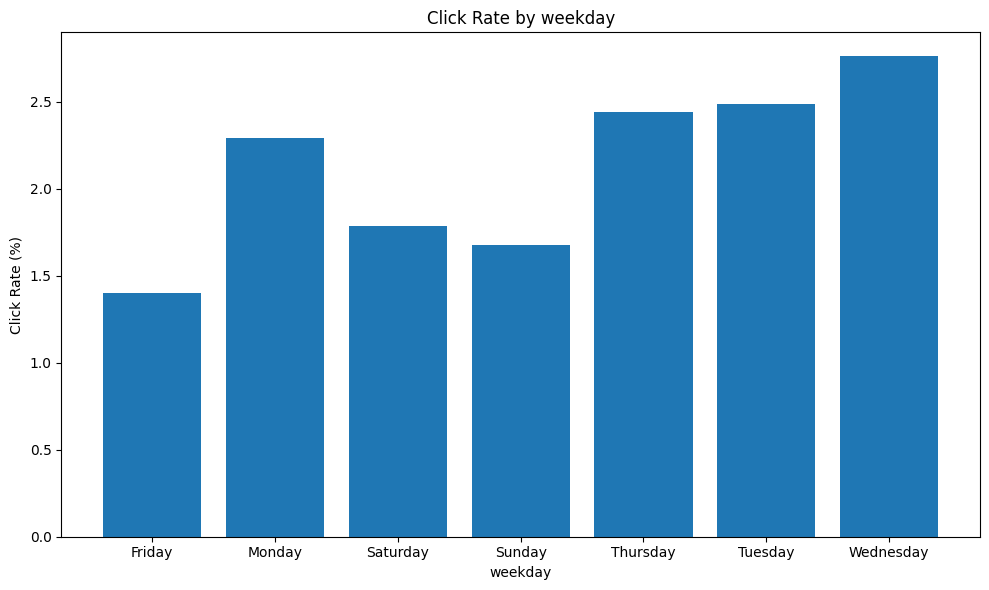


Performance by user_country:
user_country  count  open_rate  click_rate
          UK  19939  12.016651    2.467526
          US  60099  11.902028    2.435981
          ES   9967   3.912913    0.832748
          FR   9995   4.062031    0.800400


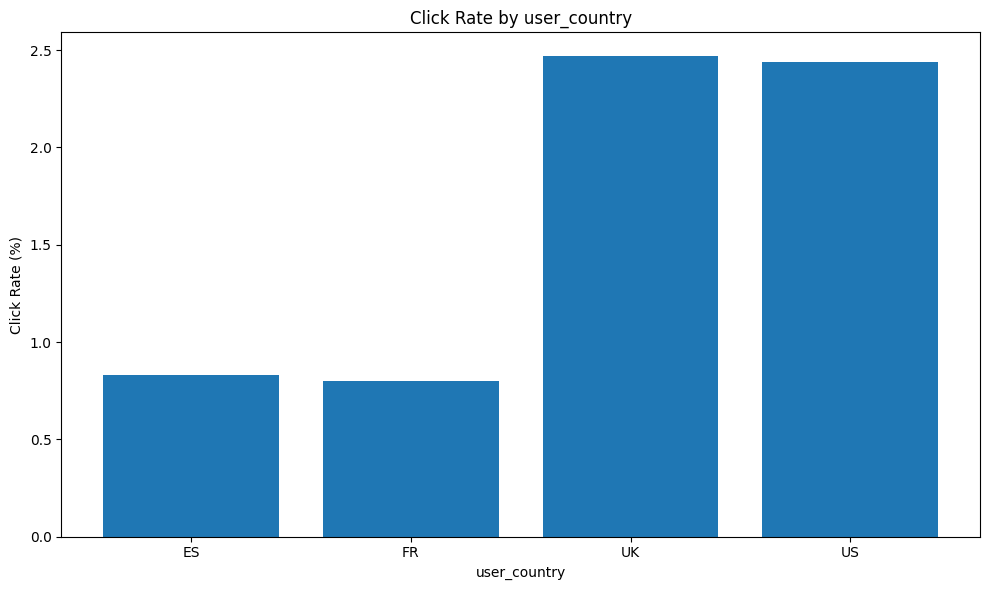


Performance by purchase history:
                count  click_rate
purchase_group                   
0               13751    1.119919
1-3             25113    1.592801
4-5             19785    2.178418
6-10            23621    3.645062
10+              3853    6.903711


/tmp/ipykernel_158875/3201386157.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_stats = original_df.groupby('purchase_group').agg({


In [22]:
#Segment analysis
original_df = pd.read_csv('data/email_table.csv')
original_df['opened'] = original_df['email_id'].isin(opened_df['email_id']).astype(int)
original_df['clicked'] = original_df['email_id'].isin(clicked_df['email_id']).astype(int)

# Analysis by segments
segments = ['email_text', 'email_version', 'hour', 'weekday', 'user_country']

for segment in segments:
    print(f"\nPerformance by {segment}:")
    segment_stats = original_df.groupby(segment).agg({
        'opened': ['count', 'mean'],
        'clicked': 'mean'
    })
    segment_stats.columns = ['count', 'open_rate', 'click_rate']
    segment_stats['open_rate'] = segment_stats['open_rate'] * 100
    segment_stats['click_rate'] = segment_stats['click_rate'] * 100

    # Reset index for better display
    segment_stats = segment_stats.reset_index()
    print(segment_stats.sort_values('click_rate', ascending=False).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.bar(segment_stats[segment].astype(str), segment_stats['click_rate'])
    plt.title(f'Click Rate by {segment}')
    plt.ylabel('Click Rate (%)')
    plt.xlabel(segment)
    plt.tight_layout()
    plt.show()

# Purchase history analysis
original_df['purchase_group'] = pd.cut(
    original_df['user_past_purchases'], 
    bins=[0, 1, 3, 5, 10, float('inf')],
    labels=['0', '1-3', '4-5', '6-10', '10+']
)
purchase_stats = original_df.groupby('purchase_group').agg({
    'clicked': ['count', 'mean']
})
purchase_stats.columns = ['count', 'click_rate']
purchase_stats['click_rate'] = purchase_stats['click_rate'] * 100
print("\nPerformance by purchase history:")
print(purchase_stats)

### Expected Improvement and Testing Methodology

In [ ]:
# Estimate improvement over random sending
# Use best model (XGBoost) to predict top 20% most likely to click
X_all = X.copy()
y_all = y.copy()

# Probability predictions on all data
if hasattr(best_xgb, "predict_proba"):
    y_all_proba = best_xgb.predict_proba(X_all)[:, 1]
    
    # Find threshold to select top 20% of users
    threshold = np.percentile(y_all_proba, 80)
    
    # Calculate expected improvement
    targeted_users = y_all[y_all_proba >= threshold]
    targeted_ctr = targeted_users.mean() * 100
    random_ctr = y_all.mean() * 100
    
    improvement = (targeted_ctr / random_ctr - 1) * 100
    
    print(f"\nExpected Improvement:")
    print(f"Random send CTR: {random_ctr:.2f}%")
    print(f"Targeted send CTR: {targeted_ctr:.2f}%")
    print(f"Percentage improvement: {improvement:.2f}%")
    
    print("\nTesting methodology:")
    print("1. Divide users into A/B test groups")
    print("2. Send to group A using model targeting")
    print("3. Send to group B randomly")
    print("4. Measure CTR for both groups and compare")


Expected Improvement:
Random send CTR: 2.12%
Targeted send CTR: 10.53%
Percentage improvement: 396.70%

Testing methodology:
1. Divide users into A/B test groups
2. Send to group A using model targeting
3. Send to group B randomly
4. Measure CTR for both groups and compare
